<a href="https://colab.research.google.com/github/g1anci/ecl2_ex03/blob/main/Sign_Language_Motion_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- **Author:** Zifan Jiang
- **Email:** zifan.jiang@uzh.ch
- **Affiliation:** University of Zurich  
- **Date:** 2025-03-06

# Recap: Sign Language Representations

Representation is a significant challenge for Sign Language Processing (SLP). Unlike spoken languages, signed languages have no widely adopted written form. As signed languages are conveyed through the visual-gestural modality, video recording is the most straightforward way to capture them. However, as videos include more information than needed for modeling and are expensive to record, store, and transmit, a lower-dimensional representation has been sought after.

The following figure (from https://research.sign.mt/) illustrates some common signed language representations. In this demonstration, we deconstruct the video into its individual frames to exemplify the alignment of the annotations between the video and representations.

![Sign Language Representations from https://research.sign.mt/](https://drive.google.com/uc?id=15R5i7fPJMVRqKgiclMghRiXjdf8nGCch)


In this notebook, we will dig into and show some live examples of how to convert between some of these representations.

**Citation**

```
@inproceedings{yin-etal-2021-including,
    title = "Including Signed Languages in Natural Language Processing",
    author = "Yin, Kayo  and
      Moryossef, Amit  and
      Hochgesang, Julie  and
      Goldberg, Yoav  and
      Alikhani, Malihe",
    editor = "Zong, Chengqing  and
      Xia, Fei  and
      Li, Wenjie  and
      Navigli, Roberto",
    booktitle = "Proceedings of the 59th Annual Meeting of the Association for Computational Linguistics and the 11th International Joint Conference on Natural Language Processing (Volume 1: Long Papers)",
    month = aug,
    year = "2021",
    address = "Online",
    publisher = "Association for Computational Linguistics",
    url = "https://aclanthology.org/2021.acl-long.570",
    doi = "10.18653/v1/2021.acl-long.570",
    pages = "7347--7360"
}
```

# Video to Pose: Pose Estimation

 Videos are the most straightforward representation of a signed language and can amply incorporate the information conveyed through signing. One major drawback of using videos is their high dimensionality: They usually include more information than needed for modeling and are expensive to store, transmit, and encode.

 Skeletal poses reduce the visual cues in videos to skeleton-like wireframes or mesh representing the location of joints. This technique has been extensively used in the field of computer vision to estimate human pose from video data, where the goal is to determine the spatial configuration of the body at each point in time.

 In this notebook, we use [MediaPipe Holistic](https://github.com/google/mediapipe/blob/master/docs/solutions/holistic.md#mediapipe-holistic) and the command line tools developed in the [pose](https://github.com/sign-language-processing/pose) library to do pose estimation on sign language videos.

We start with installing the following dependencies:

In [ ]:
! pip install -q mediapipe
! pip install -q vidgear
! pip install -q pose-format

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.0/122.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.7/96.7 kB 2.3 MB/s eta 0:00:00


## "The sun is hot." from Spreadthesign

We then download a sign language video in American Sign Language (ASL) that corresponds to "The sun is hot." in English from [Spreadthesign](https://www.spreadthesign.com/).

In [ ]:
! curl https://media.spreadthesign.com/video/mp4/13/93828.mp4 --output test.mp4

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  149k  100  149k    0     0   939k      0 --:--:-- --:--:-- --:--:--  941k


To convert the video into pose, use the `video_to_pose` command, which generates a `.pose` binary file.

In [ ]:
! video_to_pose -i /content/test.mp4 --format mediapipe -o /content/test.pose

2025-02-19 18:17:16.785178: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739989036.816721   93785 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739989036.826830   93785 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Loading video ...
Estimating pose ...
0it [00:00, ?it/s]INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1739989041.170400   93834 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1739989041.388892   93834 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. D

Now that we have the `.pose` binary file, we develop a function that takes a `.pose` file as input and then save the visualization of the pose as a `.mp4` video file.

In [ ]:
from pose_format import Pose
from pose_format.pose_visualizer import PoseVisualizer

import mediapipe as mp

mp_holistic = mp.solutions.holistic
FACEMESH_CONTOURS_POINTS = [str(p) for p in sorted(set([p for p_tup in list(mp_holistic.FACEMESH_CONTOURS) for p in p_tup]))]

def pose_visualize(pose_path, video_path=None):
    # Read
    print('Reading ...')
    with open(pose_path, "rb") as f:
        buffer = f.read()
        pose = Pose.read(buffer)
        pose = pose.get_components(["POSE_LANDMARKS", "FACE_LANDMARKS", "LEFT_HAND_LANDMARKS", "RIGHT_HAND_LANDMARKS"], {"FACE_LANDMARKS": FACEMESH_CONTOURS_POINTS})

    # Visualize
    v = PoseVisualizer(pose, thickness=1)

    # Write
    if video_path:
        print("{}.overlay.mp4".format(pose_path))
        output_path = "{}.overlay.mp4".format(pose_path)
        v.save_video(output_path, v.draw_on_video(video_path))
    else:
        print("{}.mp4".format(pose_path))
        output_path = "{}.mp4".format(pose_path)
        v.save_video(output_path, v.draw())

    return output_path

Let's try the function and display the output video.

In [ ]:
from IPython.display import HTML
from base64 import b64encode

pose_path = '/content/test.pose'
video_path = '/content/test.mp4'
visualization_path = pose_visualize(pose_path, video_path)

mp4 = open(visualization_path, 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=480 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Reading ...
/content/test.pose.overlay.mp4


0it [00:00, ?it/s]18:17:31 ::   WriteGear   :: WARNING  :: Optional `-disable_ffmpeg_window` flag is only available on Windows OS with `logging=False`. Discarding!
110it [00:02, 46.53it/s]


Looks good!

## Test your own video/pose

Let's try record and test a video of your own. Run the following code cell to define the functions for video recoding.

(Code for video recoding taken from https://colab.research.google.com/drive/1ikW3t-qXmQ6ZZMtQgdY-cJX9xbvlKzVt?usp=sharing)

In [ ]:
from IPython.display import display, Javascript,HTML
from google.colab.output import eval_js
from base64 import b64decode

from IPython.display import HTML
from base64 import b64encode

def record_video(filename):
  js=Javascript("""
    async function recordVideo() {
      const options = { mimeType: "video/webm; codecs=vp9" };
      const div = document.createElement('div');
      const capture = document.createElement('button');
      const stopCapture = document.createElement("button");

      capture.textContent = "Start Recording";
      capture.style.background = "orange";
      capture.style.color = "white";

      stopCapture.textContent = "Stop Recording";
      stopCapture.style.background = "red";
      stopCapture.style.color = "white";
      div.appendChild(capture);

      const video = document.createElement('video');
      const recordingVid = document.createElement("video");
      video.style.display = 'block';

      const stream = await navigator.mediaDevices.getUserMedia({audio:true, video: true});

      let recorder = new MediaRecorder(stream, options);
      document.body.appendChild(div);
      div.appendChild(video);

      video.srcObject = stream;
      video.muted = true;

      await video.play();

      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      await new Promise((resolve) => {
        capture.onclick = resolve;
      });
      recorder.start();
      capture.replaceWith(stopCapture);

      await new Promise((resolve) => stopCapture.onclick = resolve);
      recorder.stop();
      let recData = await new Promise((resolve) => recorder.ondataavailable = resolve);
      let arrBuff = await recData.data.arrayBuffer();

      // stop the stream and remove the video element
      stream.getVideoTracks()[0].stop();
      div.remove();

      let binaryString = "";
      let bytes = new Uint8Array(arrBuff);
      bytes.forEach((byte) => {
        binaryString += String.fromCharCode(byte);
      })
    return btoa(binaryString);
    }
  """)
  try:
    display(js)
    data=eval_js('recordVideo({})')
    binary=b64decode(data)
    with open(filename,"wb") as video_file:
      video_file.write(binary)
    print(f"Finished recording video at:{filename}")
  except Exception as err:
    print(str(err))

def show_video(video_path, video_width = 600):

  video_file = open(video_path, "r+b").read()

  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

Now Excute it. You will see a web cemera, record yourself, and it saves to own.mp4.

NOTE: if your device/browser does not allow a camera or you fail to record from the notebook, you can also record a video on your own and then upload it to the notebook through the folder shown in the menu on the left side.

In [ ]:
video_path = "own.mp4"
record_video(video_path)
show_video(video_path)

<IPython.core.display.Javascript object>

Finished recording video at:own.mp4


Once again, run and visualize the pose estimation of your own video.

In [ ]:
! video_to_pose -i own.mp4 --format mediapipe -o own.pose

2025-02-19 18:21:00.552538: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739989260.566538   94783 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739989260.570653   94783 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Loading video ...
Estimating pose ...
0it [00:00, ?it/s]INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1739989263.464623   94822 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1739989263.509244   94821 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. D

In [ ]:
pose_path = '/content/own.pose'
video_path = '/content/own.mp4'
visualization_path = pose_visualize(pose_path, video_path)

mp4 = open(visualization_path, 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=480 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Reading ...
/content/own.pose.overlay.mp4


0it [00:00, ?it/s]15:36:54 ::   WriteGear   :: WARNING  :: Optional `-disable_ffmpeg_window` flag is only available on Windows OS with `logging=False`. Discarding!
132it [00:02, 46.89it/s]


**Citation**

```
@article{moryossef2023pose,
  title={pose-format: Library for viewing, augmenting, and handling. pose files},
  author={Moryossef, Amit and M{\"u}ller, Mathias and Fahrni, Rebecka},
  journal={arXiv preprint arXiv:2310.09066},
  year={2023}
}
```


# Pose-based Sign Language Motion Analysis

## "Thank you" in different sign languages

In this part, we will see an example of sign language motion analysis based on the estimated poses.

Our specific questions are:
- how are the phrase "thank you" signed in different sign languges?
- in which language does it look the most similar to the American Sign Language (ASL) version?

To start, we download the videos of "thank you" of five sign languages and do pose estimation as was done before.

We can also see all the videos on [Spreadthesign](https://www.spreadthesign.com/) by searching the sentence "thank you".

In [ ]:
! curl https://media.spreadthesign.com/video/mp4/13/153748.mp4 --output thankyou_asl.mp4
! curl https://media.spreadthesign.com/video/mp4/10/267020.mp4 --output thankyou_lsf.mp4 # French
! curl https://media.spreadthesign.com/video/mp4/5/179391.mp4 --output thankyou_lse.mp4 # Spanish
! curl https://media.spreadthesign.com/video/mp4/35/363390.mp4 --output thankyou_csl.mp4 # Chinese
! curl https://media.spreadthesign.com/video/mp4/7/404770.mp4 --output thankyou_jsl.mp4 # Japan

! video_to_pose -i thankyou_asl.mp4 --format mediapipe -o thankyou_asl.pose
! video_to_pose -i thankyou_bsl.mp4 --format mediapipe -o thankyou_bsl.pose
! video_to_pose -i thankyou_lsf.mp4 --format mediapipe -o thankyou_lsf.pose
! video_to_pose -i thankyou_lse.mp4 --format mediapipe -o thankyou_lse.pose
! video_to_pose -i thankyou_csl.mp4 --format mediapipe -o thankyou_csl.pose
! video_to_pose -i thankyou_jsl.mp4 --format mediapipe -o thankyou_jsl.pose

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 90558  100 90558    0     0   150k      0 --:--:-- --:--:-- --:--:--  150k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 46307  100 46307    0     0  66889      0 --:--:-- --:--:-- --:--:-- 66821
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  125k  100  125k    0     0   142k      0 --:--:-- --:--:-- --:--:--  141k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   99k  100   99k    0     0   396k      0 --:--:-- --:--:-- --:--:--  397k
  % Total    % Received % Xferd  Average Speed   Tim

Visulize the videos and the poses!

In [ ]:
from IPython.display import HTML, display
from base64 import b64encode

# List of video files and their titles
videos = [
    ("ASL", "thankyou_asl.mp4"),
    ("LSF", "thankyou_lsf.mp4"),
    ("LSE", "thankyou_lse.mp4"),
    ("CSL", "thankyou_csl.mp4"),
    ("JSL", "thankyou_jsl.mp4")
]

# Create HTML content
video_html = ['<div style="display: flex; flex-wrap: wrap; gap: 20px; justify-content: center;">']

for title, video_path in videos:
    # Generate pose file path from video path
    pose_path = video_path.replace('.mp4', '.pose')

    # Generate visualization video
    visualization_path = pose_visualize(pose_path, video_path)

    # Read and encode visualization video
    mp4 = open(visualization_path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

    # Add video element
    video_html.append(f"""
    <div style="flex: 1 1 200px;">
        <h4>{title}</h4>
        <video width="200" height="200" controls>
            <source src="{data_url}" type="video/mp4">
        </video>
    </div>
    """)

video_html.append('</div>')

# Display the videos
display(HTML(''.join(video_html)))

Reading ...
thankyou_asl.pose.overlay.mp4


0it [00:00, ?it/s]12:56:37 ::   WriteGear   :: WARNING  :: Optional `-disable_ffmpeg_window` flag is only available on Windows OS with `logging=False`. Discarding!
99it [00:02, 37.59it/s]


Reading ...
thankyou_lsf.pose.overlay.mp4


0it [00:00, ?it/s]12:56:40 ::   WriteGear   :: WARNING  :: Optional `-disable_ffmpeg_window` flag is only available on Windows OS with `logging=False`. Discarding!
95it [00:01, 57.58it/s]


Reading ...
thankyou_lse.pose.overlay.mp4


0it [00:00, ?it/s]12:56:41 ::   WriteGear   :: WARNING  :: Optional `-disable_ffmpeg_window` flag is only available on Windows OS with `logging=False`. Discarding!
98it [00:01, 54.05it/s]


Reading ...
thankyou_csl.pose.overlay.mp4


0it [00:00, ?it/s]12:56:43 ::   WriteGear   :: WARNING  :: Optional `-disable_ffmpeg_window` flag is only available on Windows OS with `logging=False`. Discarding!
83it [00:02, 36.11it/s]


Reading ...
thankyou_jsl.pose.overlay.mp4


0it [00:00, ?it/s]12:56:46 ::   WriteGear   :: WARNING  :: Optional `-disable_ffmpeg_window` flag is only available on Windows OS with `logging=False`. Discarding!
61it [00:01, 46.46it/s]


# (ADVANCED) Computational Analysis

## Keypoint trajectory from a pose

Now we make a function to:
- get the `Pose` object by file path,
- normalize the body size (the mean distance between the shoulders of each person equals 1, and the mid-point is at (0, 0)),
- and then check its data shape.

In [ ]:
def get_pose(pose_path: str, components=["POSE_LANDMARKS", "FACE_LANDMARKS", "LEFT_HAND_LANDMARKS", "RIGHT_HAND_LANDMARKS"]):
    with open(pose_path, 'rb') as f:
        pose = Pose.read(f.read())

    pose = pose.normalize()
    pose = pose.get_components(components)

    return pose

pose_asl = get_pose('thankyou_asl.pose')
pose_asl_data = pose_asl.body.data.squeeze(1)
print(pose_asl_data.shape)

(99, 543, 3)


So basically this `Pose` object consists of 99 frames x 543 body keypoints x 3 channels in a 3D space (x, y, z).

We can select the trajectory of a specific keypoint (e.g., the right wrist) over the time/frames.

In [ ]:
pose_asl_right_wrist_trajectory = pose_asl.get_components(components=["RIGHT_HAND_LANDMARKS"]).body.data.squeeze(1)[:,0,:]
print(pose_asl_right_wrist_trajectory.shape)

(99, 3)


Then we do the same for the French Sign Language (LSF) pose.

In [ ]:
pose_lsf_right_wrist_trajectory = get_pose('thankyou_lsf.pose').get_components(components=["RIGHT_HAND_LANDMARKS"]).body.data.squeeze(1)[:,0,:]
print(pose_lsf_right_wrist_trajectory.shape)

(95, 3)


Plot the two trajectories of the right wrist in comparison (without the Z/depth axis).

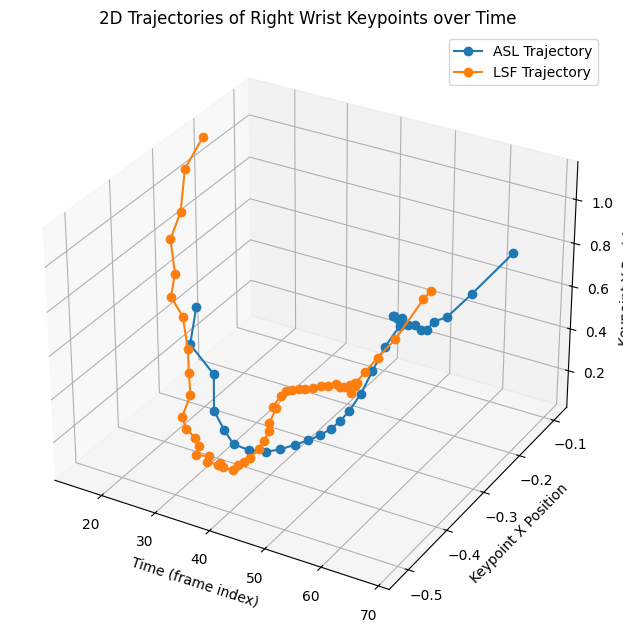

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # registers the 3D projection

# Assume your trajectories are defined as:
# pose_asl_right_wrist_trajectory with shape (99, 3)
# pose_lsf_right_wrist_trajectory with shape (95, 3)

# Generate time arrays based on the number of frames in each trajectory
time_asl = np.arange(pose_asl_right_wrist_trajectory.shape[0])
time_lsf = np.arange(pose_lsf_right_wrist_trajectory.shape[0])

# Create the 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the ASL trajectory
ax.plot(
    time_asl,
    pose_asl_right_wrist_trajectory[:, 0],  # x position (for y-axis)
    pose_asl_right_wrist_trajectory[:, 1],  # y position (for z-axis)
    label='ASL Trajectory',
    marker='o'
)

# Plot the LSF trajectory
ax.plot(
    time_lsf,
    pose_lsf_right_wrist_trajectory[:, 0],  # x position (for y-axis)
    pose_lsf_right_wrist_trajectory[:, 1],  # y position (for z-axis)
    label='LSF Trajectory',
    marker='o'
)

# Label the axes
ax.set_xlabel('Time (frame index)')
ax.set_ylabel('Keypoint X Position')
ax.set_zlabel('Keypoint Y Position')
ax.set_title('2D Trajectories of Right Wrist Keypoints over Time')

# Add a legend
ax.legend()

plt.subplots_adjust(left=0.2, right=0.95, top=0.95, bottom=0.1)

# Show the plot
plt.show()

Looks close! Both contain a clear motion to lift the hand up and then return to the rest position.


## Naive trajectory distance: Average Position Error (APE)

Now a naive way to quantitatively compare the two trajectories is:

- pad the two trajectories to equal length (number of frames) by adding zero frames
- use the Euclidean distance to measure the distance between the points from the two trajectories at each frame
- fill in zero positions for these missing keypoints caused by the hand's absense in the video
- then return the averaged results over frames

In [ ]:
from scipy.spatial.distance import euclidean

def unmasked_euclidean(point1, point2):
    if np.ma.is_masked(point1):
        point1 = (0, 0, 0)
    if np.ma.is_masked(point2):
        point2 = (0, 0, 0)
    d = euclidean(point1, point2)
    return d

def APE(trajectory1, trajectory2):
    # padding
    if len(trajectory1) < len(trajectory2):
        diff = len(trajectory2) - len(trajectory1)
        trajectory1 = np.concatenate((trajectory1, np.zeros((diff, 3))))
    elif len(trajectory2) < len(trajectory1):
        trajectory2 = np.concatenate((trajectory2, np.zeros((len(trajectory1) - len(trajectory2), 3))))

    # averaged Euclidean distance
    distances = [unmasked_euclidean(trajectory1[i], trajectory2[i]) for i in range(len(trajectory1))]
    return np.mean(distances)

print(APE(pose_asl_right_wrist_trajectory, pose_lsf_right_wrist_trajectory))

0.25583157183083316


The bigger the APE value, the bigger the distance between the two trajectories is.

## Improved trajectory distance: Dynamic Time Wrapping (DTW)

An issue of the naive APE approach is that it does not align the two trajectories temporally but just pad to equal length. To overcome this shortcoming we introduce Dynamic Time Wrapping (DTW) and a customized verison of the `euclidean` function to fix masked values.

If you are not familiar with DTW, the following resource is worth checking out:

https://rtavenar.github.io/blog/dtw.html





In [ ]:
!pip -q install fastdtw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
from fastdtw import fastdtw

trajectory_length = max(len(pose_asl_right_wrist_trajectory), len(pose_lsf_right_wrist_trajectory))
fastdtw(pose_asl_right_wrist_trajectory, pose_lsf_right_wrist_trajectory, dist=unmasked_euclidean)[0] / trajectory_length

0.09002962648421489

The distance is reduced as expected since we observe the "thank you" in ASL and LSF share similar motion for the right wrist, great!

## Compare pose and find the most similar "thank you"

Now to compare the whole pose, we extend the trajectory distance to all the keypoints we are concerned with instead of the right wrist only.

In this example, we simplify the problem to selecting all the right hand 21 keypoints, assuming the signs only differ in the right hand movements across different sign languages.

To do this we make a function `compare_poses` and calculated the `total_distance` as the mean of all relevant keypoint trajectories.

In [ ]:
concerned_components = ["RIGHT_HAND_LANDMARKS"]

def get_idx2weight_mediapipe(pose):
    # TODO: weights
    idx2weight = {i: 1 for i in range(pose.body.data.shape[2])}
    return idx2weight

def compare_poses(pose1, pose2, distance_function='nfastdtw'):
    pose1 = get_pose(pose1, components=concerned_components)
    pose2 = get_pose(pose2, components=concerned_components)

    poses_data = [pose1.body.data, pose2.body.data]

    total_distance = 0
    idx2weight = get_idx2weight_mediapipe(pose1)

    for keypoint_idx, weight in idx2weight.items():
        pose1_keypoint_trajectory = poses_data[0][:, :, keypoint_idx, :].squeeze(1)
        pose2_keypoint_trajectory = poses_data[1][:, :, keypoint_idx, :].squeeze(1)

        if distance_function == 'APE':
            dist = APE(pose1_keypoint_trajectory, pose2_keypoint_trajectory)
        elif distance_function == 'fastdtw':
            dist = fastdtw(pose1_keypoint_trajectory, pose2_keypoint_trajectory, dist=unmasked_euclidean)[0] / len(pose1_keypoint_trajectory)
        total_distance += dist*weight

    return total_distance/len(idx2weight)

Let's apply to APE for all other languages in comparison to ASL.

In [ ]:
print(compare_poses('thankyou_asl.pose', 'thankyou_lsf.pose', distance_function='APE')) # French
print(compare_poses('thankyou_asl.pose', 'thankyou_lse.pose', distance_function='APE')) # Spanish
print(compare_poses('thankyou_asl.pose', 'thankyou_csl.pose', distance_function='APE')) # Chinese
print(compare_poses('thankyou_asl.pose', 'thankyou_jsl.pose', distance_function='APE')) # Japanese

0.2455398262402014
0.18163065927724903
0.1958720254402603
0.27264975394573604


The Spanish and the Chinese signs are more similar to the ASL sign than the French and the Japanese ones. How about using DTW to align the trajectories temporally?

In [ ]:
print(compare_poses('thankyou_asl.pose', 'thankyou_lsf.pose', distance_function='fastdtw'))
print(compare_poses('thankyou_asl.pose', 'thankyou_lse.pose', distance_function='fastdtw'))
print(compare_poses('thankyou_asl.pose', 'thankyou_csl.pose', distance_function='fastdtw'))
print(compare_poses('thankyou_asl.pose', 'thankyou_jsl.pose', distance_function='fastdtw'))

0.09050387768089929
0.08723304302876088
0.11820085640943259
0.23086211694357933


Now the results show that the French and Spanish signs are more similar to the ASL "thank you". Does it align better with your perception?

NOTE: in reality, both APE and DTW, as distance-based metrics, are very sensitive to the noise in space and time. Advanced usage for downstream tasks must be verified carefully and supported by empirical evidence. Do you have additional ideas to improve them?

**Citation**

```
@article{shalev2022ham2pose,
  title={Ham2Pose: Animating Sign Language Notation into Pose Sequences},
  author={Shalev-Arkushin, Rotem and Moryossef, Amit and Fried, Ohad},
  journal={arXiv preprint arXiv:2211.13613},
  year={2022}
}
```

```
@misc{pose-evaluation2024,
    title={Pose Evaluation: Metrics for Evaluating Sign Langauge Generation Models},
    author={Zifan Jiang, Colin Leong, Amit Moryossef},
    howpublished={\url{https://github.com/sign-language-processing/pose-evaluation}},
    year={2024}
}
```
